# Load Data

In [20]:
!pip install datasets

In [21]:
from datasets import load_dataset
dataset = load_dataset("derek-thomas/ScienceQA")
validation_data = dataset["validation"]
validation_data

Dataset({
    features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
    num_rows: 4241
})

### This is a normal datapoint

In [22]:
validation_data[3500]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=200x202>,
 'question': 'Is diorite a mineral or a rock?',
 'choices': ['rock', 'mineral'],
 'answer': 0,
 'hint': 'Diorite has the following properties:\nno fixed crystal structure\nnaturally occurring\nnot a pure substance\ncoarse-grained texture\nsolid\nnot made by organisms',
 'task': 'closed choice',
 'grade': 'grade8',
 'subject': 'natural science',
 'topic': 'earth-science',
 'category': 'Rocks and minerals',
 'skill': 'Identify rocks and minerals',
 'lecture': 'Minerals are the building blocks of rocks. A rock can be made of one or more minerals.\nMinerals and rocks have the following properties:\nProperty | Mineral | Rock\nIt is a solid. | Yes | Yes\nIt is formed in nature. | Yes | Yes\nIt is not made by organisms. | Yes | Yes\nIt is a pure substance. | Yes | No\nIt has a fixed crystal structure. | Yes | No\nYou can use these properties to tell whether a substance is a mineral, a rock, or neither.\nLook closely at t

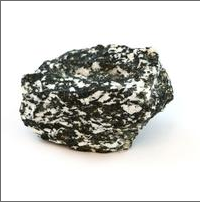

In [23]:
validation_data[3500]["image"]

### This is an abnormal datapoint with no image
But the text is enough to figure out the solution

In [24]:
validation_data[0]

{'image': None,
 'question': "What does the verbal irony in this text suggest?\nAccording to Mr. Herrera's kids, his snoring is as quiet as a jackhammer.",
 'choices': ['The snoring is loud.', 'The snoring occurs in bursts.'],
 'answer': 0,
 'hint': '',
 'task': 'closed choice',
 'grade': 'grade8',
 'subject': 'language science',
 'topic': 'figurative-language',
 'category': 'Literary devices',
 'skill': 'Interpret figures of speech',
 'lecture': 'Figures of speech are words or phrases that use language in a nonliteral or unusual way. They can make writing more expressive.\nVerbal irony involves saying one thing but implying something very different. People often use verbal irony when they are being sarcastic.\nOlivia seems thrilled that her car keeps breaking down.\nEach breakdown is as enjoyable as a punch to the face.',
 'solution': "The text uses verbal irony, which involves saying one thing but implying something very different.\nAs quiet as a jackhammer suggests that the snoring 

### This is a bad abnormal datapoint
Image is part of the task input and is missing. The solution is also missing.

In [25]:
validation_data[4240]

{'image': None,
 'question': 'What information supports the conclusion that Rick inherited this trait?',
 'choices': ["Rick's coworker also has curly hair.",
  "Rick's biological father has curly hair.",
  'Rick and his biological parents have brown hair.'],
 'answer': 1,
 'hint': 'Read the description of a trait.\nRick has curly hair.',
 'task': 'closed choice',
 'grade': 'grade7',
 'subject': 'natural science',
 'topic': 'biology',
 'category': 'Genes to traits',
 'skill': 'Inherited and acquired traits: use evidence to support a statement',
 'lecture': "Organisms, including people, have both inherited and acquired traits. Inherited and acquired traits are gained in different ways.\nInherited traits are passed down from biological parents to their offspring through genes. Genes are pieces of hereditary material that contain the instructions that affect inherited traits. Offspring receive their genes, and therefore gain their inherited traits, from their biological parents. Inherited 

In [27]:
dir(validation_data[4240])

['__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [26]:
filtered_validation_data = validation_data.filter(lambda example: example["lecture"] != "" and example["solution"] != "")
filtered_validation_data

Dataset({
    features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
    num_rows: 3216
})

# Experiment with Models

In [ ]:
import torch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
from abc import ABC, abstractmethod

class Model(ABC):
    """Abstract base class for models with custom processing."""

    def __init__(self, model_name: str):
        self.model_name = model_name
        self.model = self.load_model()
        self.processor = self.load_processor()

    @abstractmethod
    def load_model(self):
        """Load the model architecture and weights."""
        pass

    @abstractmethod
    def load_processor(self):
        """Load the processor associated with the model."""
        pass

    @abstractmethod
    def process(self, *args, **kwargs):
        """Define the processing logic for the model."""
        pass

## Preliminary Experiments

In [ ]:
class LLaVAModel(Model):
    def load_model(self):
        from transformers import LlavaForConditionalGeneration
        return LlavaForConditionalGeneration.from_pretrained(
            self.model_name,
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True)

    def load_processor(self):
        from transformers import AutoProcessor
        return AutoProcessor.from_pretrained(self.model_name)

    def process(self, text_input, image, **kwargs):
        # Workaround for "Expanding inputs for image tokens in LLaVa-NeXT should be done in processing."
        # from https://huggingface.co/llava-hf/llava-v1.6-mistral-7b-hf/discussions/34
        self.processor.patch_size = self.model.config.vision_config.patch_size
        self.processor.vision_feature_select_strategy = self.model.config.vision_feature_select_strategy

        # Define a chat histiry and use `apply_chat_template` to get correctly formatted prompt
        # Each value in "content" has to be a list of dicts with types ("text", "image")
        conversation = [
            {
              "role": "user",
              "content": [
                  {"type": "text", "text": text_input},
                  {"type": "image"},
                ],
            },
        ]
        prompt = self.processor.apply_chat_template(conversation, add_generation_prompt=True)
        inputs = self.processor(images=image, text=prompt, return_tensors='pt').to(device, torch.float16)
        self.model = self.model.to(device)
        with torch.no_grad():
          output = self.model.generate(**inputs, max_new_tokens=200, do_sample=False)
          response = self.processor.decode(output[0][2:], skip_special_tokens=True)

        print(f"\nPrompt:\n {prompt}")
        print(f"\nModel response:\n {response}")
        return response

In [ ]:
models = {
    "LLaVAModel1.5-7b": LLaVAModel("llava-hf/llava-1.5-7b-hf")
}

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

### Prompt LLaVa with a chat setting
- additional user-defined instruction: `You are a helpful assistant. Answer the user's request to the best of your knowledge.`
- output format instruction: `Solve task. Return JSON: {"answer": "choice number", "solution": "your step-by-step thinking"}`

**Notes**:
- (?) possibility of empty responses of ASSISTANT (e.g. first example, `QTCHL` setting) -- why?
- (!) output format instruction `Return JSON: {"answer": "choice number", "solution": "your step-by-step thinking"}` actually resulted in `ASSISTANT: {"answer": "choice number", "solution": "your step-by-step thinking"}` in some cases.
- in other cases the format was correct, although the answer is different from the golden answer (and the model can actually justify its reasoning with some plausible) -- could this be the result of "the best of your knowledge"?

In [ ]:
n = 3500
#QCMIT
def process_datapoint(model, n):
  system_prompt = "You are a helpful assistant. Answer the user's request to the best of your knowledge."
  question = validation_data[n]["question"]
  context = validation_data[n]["hint"]
  choice = validation_data[n]["choices"]
  image = validation_data[n]["image"]
  task = validation_data[n]["task"]
  lecture = validation_data[n]["lecture"]
  solution = validation_data[n]["solution"]
  prompt_answer_and_solution = '\nSolve task. Return JSON: {"answer": "choice number", "solution": "your step-by-step thinking"}'
  prompt_answer_only = '\nSolve task. Return JSON: {"answer": "choice number"}'

  # text_input = f"Question: {question}\nContext: {context}\nOptions: {choice}\nTask: {task}"
  # QTCH
  text_input = f"{system_prompt} Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context}\n Instruction: {prompt_answer_and_solution}"
  model.process(text_input=text_input, image=image)
  # QTCHL
  text_input = f"{system_prompt} Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context} \nLecture: {lecture}\n Instruction: {prompt_answer_and_solution}"
  model.process(text_input=text_input, image=image)
  # QTCHLS
  text_input = f"{system_prompt} Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context} \nLecture: {lecture}\nSolution: {solution}\n Instruction: {prompt_answer_only}"
  model.process(text_input=text_input, image=image)

In [ ]:
model = models["LLaVAModel1.5-7b"]
process_datapoint(model, n)

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.



Prompt:
 USER: <image>
You are a helpful assistant. Answer the user's request to the best of your knowledge. Question: Is diorite a mineral or a rock?
 Task: closed choice
 Choices: ['rock', 'mineral']
 Hint: Diorite has the following properties:
no fixed crystal structure
naturally occurring
not a pure substance
coarse-grained texture
solid
not made by organisms
 Instruction: 
Solve task. Return JSON: {"answer": "choice number", "solution": "your step-by-step thinking"} ASSISTANT:

Model response:
 ER:  
You are a helpful assistant. Answer the user's request to the best of your knowledge. Question: Is diorite a mineral or a rock?
 Task: closed choice
 Choices: ['rock', 'mineral']
 Hint: Diorite has the following properties:
no fixed crystal structure
naturally occurring
not a pure substance
coarse-grained texture
solid
not made by organisms
 Instruction: 
Solve task. Return JSON: {"answer": "choice number", "solution": "your step-by-step thinking"} ASSISTANT: {"answer": "mineral", "s

In [ ]:
n = 2400
model = models["LLaVAModel1.5-7b"]
process_datapoint(model, n)


Prompt:
 USER: <image>
You are a helpful assistant. Answer the user's request to the best of your knowledge. Question: Which better describes the Monongahela National Forest ecosystem?
 Task: closed choice
 Choices: ['It has soil that is poor in nutrients. It also has only a few types of trees.', 'It has cold, wet winters. It also has soil that is rich in nutrients.']
 Hint: Figure: Monongahela National Forest.
The Monongahela National Forest is a temperate deciduous forest ecosystem in eastern West Virginia.
 Instruction: 
Solve task. Return JSON: {"answer": "choice number", "solution": "your step-by-step thinking"} ASSISTANT:

Model response:
 ER:  
You are a helpful assistant. Answer the user's request to the best of your knowledge. Question: Which better describes the Monongahela National Forest ecosystem?
 Task: closed choice
 Choices: ['It has soil that is poor in nutrients. It also has only a few types of trees.', 'It has cold, wet winters. It also has soil that is rich in nutr

In [ ]:
# won't work since the image is none
# n = 1500
# model = models["LLaVAModel1.5-7b"]
# process_datapoint(model, n)

### Prompt LLaVa with a chat setting (2)
- no additional user instruction (as there is already one handled implicitly by `self.processor.apply_chat_template(conversation, add_generation_prompt=True)` above at model definition
- output format instruction: `\nPlease output the answer in JSON style with an answer and a solution field`

**Notes**:
- some answers are still empty, but for the rest -
- **now, the answers are correct**! Diorite is now a rock, not a mineral! Was it really because of the "to the best of your knowledge" part, or is the output format instruction also infuencing the generation?

In [ ]:
def process_datapoint(model, n):
  question = validation_data[n]["question"]
  context = validation_data[n]["hint"]
  choice = validation_data[n]["choices"]
  image = validation_data[n]["image"]
  task = validation_data[n]["task"]
  lecture = validation_data[n]["lecture"]
  solution = validation_data[n]["solution"]
  prompt_answer_and_solution = '\nPlease output the answer in JSON style with an answer and a solution field'

  # text_input = f"Question: {question}\nContext: {context}\nOptions: {choice}\nTask: {task}"
  # QTCH
  text_input = f"Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context}\n Instruction: {prompt_answer_and_solution}"
  model.process(text_input=text_input, image=image)
  # QTCHL
  text_input = f"Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context} \nLecture: {lecture}\n Instruction: {prompt_answer_and_solution}"
  model.process(text_input=text_input, image=image)
  # QTCHLS
  text_input = f"Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context} \nLecture: {lecture}\nSolution: {solution}\n Instruction: {prompt_answer_and_solution}"
  model.process(text_input=text_input, image=image)
  # QTCHS
  text_input = f"Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context} \nSolution: {solution}\n Instruction: {prompt_answer_and_solution}"
  model.process(text_input=text_input, image=image)

In [ ]:
n = 3500
model = models["LLaVAModel1.5-7b"]
process_datapoint(model, n)


Prompt:
 USER: <image>
Question: Is diorite a mineral or a rock?
 Task: closed choice
 Choices: ['rock', 'mineral']
 Hint: Diorite has the following properties:
no fixed crystal structure
naturally occurring
not a pure substance
coarse-grained texture
solid
not made by organisms
 Instruction: 
Please output the answer in JSON style with an answer and a solution field ASSISTANT:

Model response:
 ER:  
Question: Is diorite a mineral or a rock?
 Task: closed choice
 Choices: ['rock', 'mineral']
 Hint: Diorite has the following properties:
no fixed crystal structure
naturally occurring
not a pure substance
coarse-grained texture
solid
not made by organisms
 Instruction: 
Please output the answer in JSON style with an answer and a solution field ASSISTANT: {
"answer": "rock",
"solution": "Diorite is a rock, not a mineral. It is a coarse-grained, solid, naturally occurring substance that has no fixed crystal structure and is not made by organisms."
}

Prompt:
 USER: <image>
Question: Is di

In [ ]:
n = 2400
model = models["LLaVAModel1.5-7b"]
process_datapoint(model, n)


Prompt:
 USER: <image>
Question: Which better describes the Monongahela National Forest ecosystem?
 Task: closed choice
 Choices: ['It has soil that is poor in nutrients. It also has only a few types of trees.', 'It has cold, wet winters. It also has soil that is rich in nutrients.']
 Hint: Figure: Monongahela National Forest.
The Monongahela National Forest is a temperate deciduous forest ecosystem in eastern West Virginia.
 Instruction: 
Please output the answer in JSON style with an answer and a solution field ASSISTANT:

Model response:
 ER:  
Question: Which better describes the Monongahela National Forest ecosystem?
 Task: closed choice
 Choices: ['It has soil that is poor in nutrients. It also has only a few types of trees.', 'It has cold, wet winters. It also has soil that is rich in nutrients.']
 Hint: Figure: Monongahela National Forest.
The Monongahela National Forest is a temperate deciduous forest ecosystem in eastern West Virginia.
 Instruction: 
Please output the answer

In [ ]:
# won't work since no image
#n = 1500
#model = models["LLaVAModel1.5-7b"]
#process_datapoint(model, n)

# Process whole Dataset

In [ ]:
class LLaVAModel(Model):
    def load_model(self):
        from transformers import LlavaForConditionalGeneration
        return LlavaForConditionalGeneration.from_pretrained(
            self.model_name,
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True)

    def load_processor(self):
        from transformers import AutoProcessor
        return AutoProcessor.from_pretrained(self.model_name)

    def process(self, text_input, image, **kwargs):
        # Workaround for "Expanding inputs for image tokens in LLaVa-NeXT should be done in processing."
        # from https://huggingface.co/llava-hf/llava-v1.6-mistral-7b-hf/discussions/34
        self.processor.patch_size = self.model.config.vision_config.patch_size
        self.processor.vision_feature_select_strategy = self.model.config.vision_feature_select_strategy

        # Define a chat histiry and use `apply_chat_template` to get correctly formatted prompt
        # Each value in "content" has to be a list of dicts with types ("text", "image")
        if image:
          conversation = [
              {
                "role": "user",
                "content": [
                    {"type": "text", "text": text_input},
                    {"type": "image"},
                  ],
              },
          ]
          prompt = self.processor.apply_chat_template(conversation, add_generation_prompt=True)
          inputs = self.processor(images=image, text=prompt, return_tensors='pt').to(device, torch.float16)
        else:
          conversation = [
              {
                "role": "user",
                "content": [
                    {"type": "text", "text": text_input},
                  ],
              },
          ]
          prompt = self.processor.apply_chat_template(conversation, add_generation_prompt=True)
          inputs = self.processor(text=prompt, return_tensors='pt').to(device, torch.float16)
        self.model = self.model.to(device)
        with torch.no_grad():
          output = self.model.generate(**inputs, max_new_tokens=200, do_sample=False)
          response = self.processor.decode(output[0][2:], skip_special_tokens=True)

        response = response.split("ASSISTANT:")[1] #only take what follows after keyword ASSISTANT (the actual chat response)
        print(f"\nPrompt:\n {prompt}")
        print(f"\nModel response:\n {response}")
        return response

In [ ]:
models = {
    "LLaVAModel1.5-7b": LLaVAModel("llava-hf/llava-1.5-7b-hf")
}

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# results = {"LLaVAModel1.5-7b": {"QTCH": [], "QTCHL": [], "QTCHLS": [], "QTCHS": []}}
# def process_datapoint(model_name, n):
#   model = models[model_name]

#   question = validation_data[n]["question"]
#   context = validation_data[n]["hint"]
#   choice = validation_data[n]["choices"]
#   image = validation_data[n]["image"]
#   task = validation_data[n]["task"]
#   lecture = validation_data[n]["lecture"]
#   solution = validation_data[n]["solution"]
#   subject = validation_data[n]["subject"]
#   prompt_answer_and_solution = '\nPlease output the answer in JSON style with an answer and a solution field'

#   # QTCH
#   text_input = f"Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context}\n Instruction: {prompt_answer_and_solution}"
#   answer = model.process(text_input=text_input, image=image)
#   results[model_name]["QTCH"].append((n, text_input, answer, subject))
#   # QTCHL
#   text_input = f"Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context} \nLecture: {lecture}\n Instruction: {prompt_answer_and_solution}"
#   model.process(text_input=text_input, image=image)
#   results[model_name]["QTCHL"].append((n, text_input, answer, subject))
#   # QTCHLS
#   text_input = f"Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context} \nLecture: {lecture}\nSolution: {solution}\n Instruction: {prompt_answer_and_solution}"
#   model.process(text_input=text_input, image=image)
#   results[model_name]["QTCHLS"].append((n, text_input, answer, subject))
#   # QTCHS
#   text_input = f"Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context} \nSolution: {solution}\n Instruction: {prompt_answer_and_solution}"
#   model.process(text_input=text_input, image=image)
#   results[model_name]["QTCHS"].append((n, text_input, answer, subject))

In [ ]:
from collections import defaultdict

# Initialize results dictionary with structure for storing outputs
results = defaultdict(lambda: defaultdict(list))

# Define the processing function adapted for map
def process_datapoint_for_map(example, idx, model_name="LLaVAModel1.5-7b"):
    model = models[model_name]

    question = example["question"]
    context = example["hint"]
    choice = example["choices"]
    image = example["image"]
    task = example["task"]
    lecture = example["lecture"]
    solution = example["solution"]
    subject = example["subject"]
    prompt_answer_and_solution = '\nPlease output the answer in JSON style with an answer and a solution field'

    processed_examples = {
        "QTCH": None,
        "QTCHL": None,
        "QTCHLS": None,
        "QTCHS": None,
    }

    # Process for each configuration
    text_input = f"Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context}\n Instruction: {prompt_answer_and_solution}"
    answer = model.process(text_input=text_input, image=image)
    processed_examples["QTCH"] = (text_input, answer, subject)

    text_input = f"Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context} \nLecture: {lecture}\n Instruction: {prompt_answer_and_solution}"
    answer = model.process(text_input=text_input, image=image)
    processed_examples["QTCHL"] = (text_input, answer, subject)

    text_input = f"Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context} \nLecture: {lecture}\nSolution: {solution}\n Instruction: {prompt_answer_and_solution}"
    answer = model.process(text_input=text_input, image=image)
    processed_examples["QTCHLS"] = (text_input, answer, subject)

    text_input = f"Question: {question}\n Task: {task}\n Choices: {choice}\n Hint: {context} \nSolution: {solution}\n Instruction: {prompt_answer_and_solution}"
    answer = model.process(text_input=text_input, image=image)
    processed_examples["QTCHS"] = (text_input, answer, subject)

    return {"index": idx, "processed_examples": processed_examples}

# Apply the processing function, passing both the example and its index
processed_data = validation_data.map(lambda example, idx: process_datapoint_for_map(example, idx, model_name="LLaVAModel1.5-7b"), with_indices=True)

# Aggregating with preserved index
for item in processed_data:
    idx = item["index"]
    result = item["processed_examples"]
    for key in result:
        results["LLaVAModel1.5-7b"][key].append((idx, *result[key]))

In [ ]:
# n = 2400
# # model = models["LLaVAModel1.5-7b"]
# model_name = "LLaVAModel1.5-7b"
# process_datapoint(model_name, n)

In [ ]:
results

# Save results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import pandas as pd

prompting_settings = ["QTCH", "QTCHL", "QTCHLS", "QTCHS"]

def save_model_results(model_name, results):
    # Define the save path
    results_save_path = f"/content/drive/MyDrive/foundation_models/benchmarking/{model_name}"

    # Create the directory if it doesn't exist
    os.makedirs(results_save_path, exist_ok=True)

    # Save each setting's results to a separate CSV
    for setting in prompting_settings:
        df = pd.DataFrame(results[model_name][setting], columns=["idx", "input", "output", "subject"])
        df.to_csv(f"{results_save_path}/{model_name}_val_output_setting_{setting}.csv", index=False, sep="\t")

# Call the function with the results dictionary
save_model_results("LLaVAModel1.5-7b", results)